In [1]:
save_root_path = '.'
fname = 'imagenet-typogrpahical-attack'
batch_size =256
eval_batch_size = 128
workers = 10
epoch = 10

class Args:
        def __init__(self, **entries):
            self.__dict__.update(entries)

args = Args(save_root_path=save_root_path,
                fname=fname,
                batch_size=batch_size,
                eval_batch_size=eval_batch_size,
                workers=workers,
                epoch=epoch)

In [2]:
import os

from matplotlib.pyplot import text
from dataloader.waterbird import Waterbird, WB_DomainTest
import clip
import torch
import clipfolder.clip as clipours
import torch.nn as nn
import argparse
import time
from PIL import Image

import random
import numpy as np

#set up the device as 2nd GPU
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")


In [3]:
model_list = []
for which_layer in [0,12]:#range(0, 13):
    model, preprocess = clipours.load('ViT-B/32', device, jit=False, extract_last_k_th_token=12 - which_layer) # model are ranked from the early layers to last layers interpretation.
    model_list.append(model)








transofmer total layers 12
 mask for layer 0
 mask for layer 1
 mask for layer 2
 mask for layer 3
 mask for layer 4
 mask for layer 5
 mask for layer 6
 mask for layer 7
 mask for layer 8
 mask for layer 9
 mask for layer 10
 mask for layer 11





transofmer total layers 12





transofmer total layers 12





transofmer total layers 12


In [4]:

def get_interpretation_from_layer(x, layer, attn_blocks, ln_post, text_features, logit_scale, ans_with_cat):
    with torch.no_grad():
        for i in range(layer,len(attn_blocks)):
            x = attn_blocks[i](x)
        
        x = x.permute(1, 0, 2)
        x = torch.cat([ln_post(x[:, idx, :]).unsqueeze(1) for idx in range(x.size(1))], dim=1)
        image_features = x @ model.visual.proj
        image_features = image_features / image_features.norm(dim=1, keepdim=True)


        logits_img = (logit_scale * image_features) @ text_features.t()

        pseudo_target = np.argmax(logits_img.cpu().numpy(), axis=2)


        ans_2 = []
        for bs in range(pseudo_target.shape[0]):
            ans_3 = []
            for it in range(0, pseudo_target.shape[1]): # for each token, put 1 here to avoid CLS token replace
                index = pseudo_target[bs, it]
                ans_3.append(ans_with_cat[index])
            ans_2.append(ans_3)

    return ans_2


In [5]:
import torchvision
from torch.utils.data import DataLoader
import torch

imagenet_root = #Fill in imagenet directory
val_dataset = torchvision.datasets.ImageFolder(
            imagenet_root,
            transform=preprocess
        )

train_sampler = None
val_sampler = None

val_loader = DataLoader(val_dataset,
                          batch_size=1, pin_memory=True,
                          num_workers=1, shuffle=False, sampler=train_sampler)

In [8]:
import pandas as pd
image_net_classes = pd.read_csv('image_net_classes.txt', delimiter=' ', header=None)
image_net_classes[2] = image_net_classes[2].apply(lambda x: x.replace('_', ' '))
image_net_classes.set_index(0, inplace=True)
image_net_classes[2] = image_net_classes[2].apply(lambda x: x.lower())

selected_classes_dir = [
    "n02690373",
    "n03417042",
    "n01644373",
    "n01734418",
    "n02108915",
    "n04285008",
    "n03792782",
    "n04273569",
    "n04228054",
    "n04398044"
]



In [15]:
all_labels = [image_net_classes.loc[cls,2] for cls in selected_classes_dir]
image_dirs = []
labels = []
spurious_texts = []
selected_root = 'selected_imagenet_val'


for category_id in os.listdir(selected_root):
    for image_fname in os.listdir(os.path.join(selected_root, category_id)):
        image_dirs.append(os.path.join(selected_root, category_id, image_fname))
        labels.append(image_net_classes.loc[category_id,2])
        spurious_text = all_labels[random.randint(0,9)]
        while spurious_text == image_net_classes.loc[category_id,2]:
            spurious_text = all_labels[random.randint(0,9)]
        spurious_texts.append(spurious_text)

df = pd.DataFrame({'image_dir': image_dirs, 'label': labels, 'spurious_text': spurious_texts})



In [16]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

fnt = ImageFont.truetype("../mic/UbuntuMono-R.ttf", 30)

class SatelliteTextPairDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_dir = self.df.iloc[idx]['image_dir']
        original_img = Image.open(img_dir).convert('RGB')
        text_img = Image.open(img_dir).convert('RGB')
        img_name = self.df.iloc[idx]['label']
        attack_word = self.df.iloc[idx]['spurious_text']
        text_img = text_img.resize((224, 224))
        
        I1 = ImageDraw.Draw(text_img)
        I1.rectangle([(0, 0), (400, 30)], fill=(0, 0, 0))
        I1.text((0, 0), attack_word, fill=(255, 255, 255), font = fnt)
        # print('painted')

        if self.transform:
            original_img = self.transform(original_img)
            text_img = self.transform(text_img)
        

        return original_img, text_img, img_name
    
class SatelliteDataset(Dataset):
    def __init__(self, df, transform=None):
        self.transform = transform
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_dir = self.df.iloc[idx]['image_dir']
        img = Image.open(img_dir).convert('RGB')
        img_name = self.df.iloc[idx]['label']

        if self.transform:
            img = self.transform(img)

        return img, img_name

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


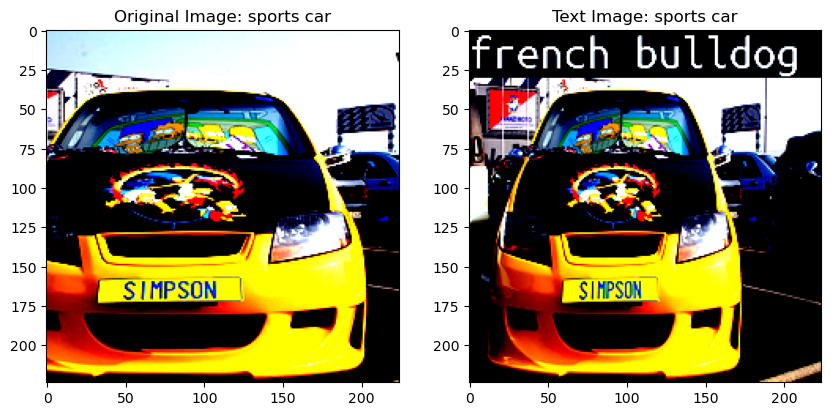

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


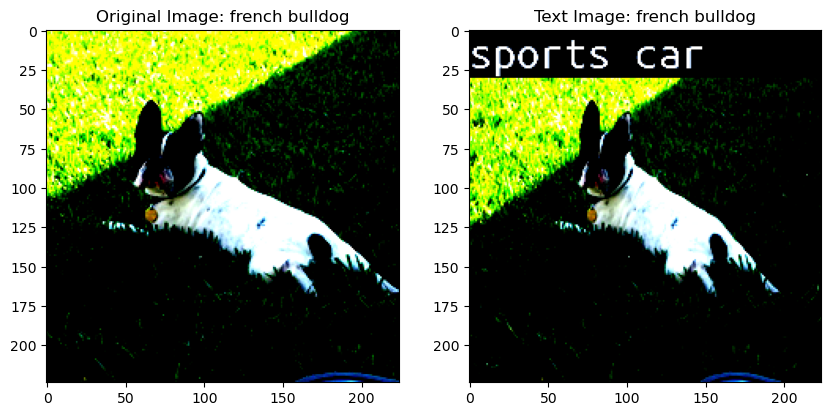

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


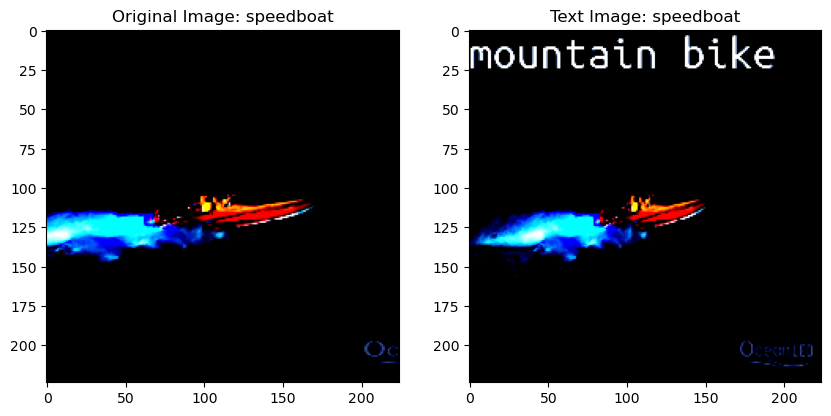

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


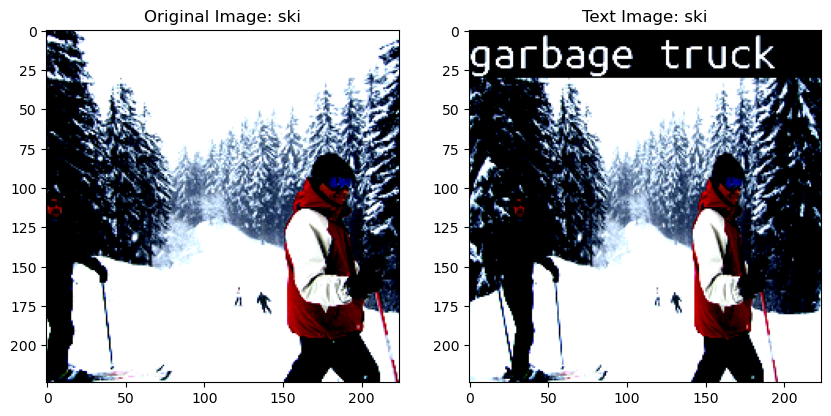

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


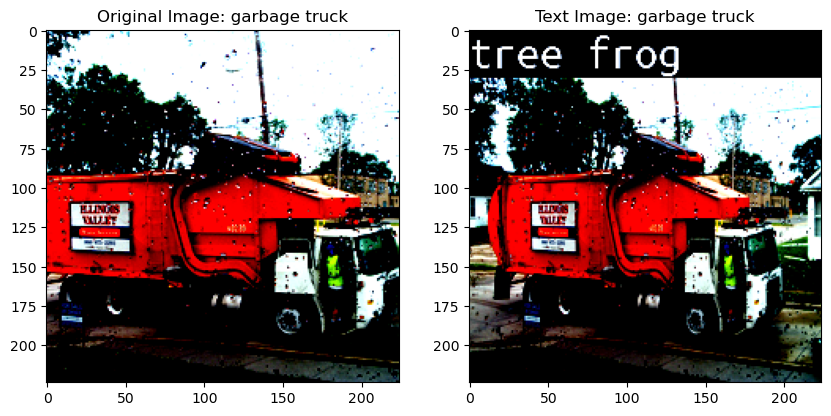

In [265]:
import matplotlib.pyplot as plt

def visualize_images(dataset, num_images):
    for i in range(num_images):
        i = random.randint(0, len(dataset))
        # i = i+ 100
        original_img, text_img, img_name = dataset[i]
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(original_img.permute(1, 2, 0))
        axs[0].set_title('Original Image: ' + img_name)
        axs[1].imshow(text_img.permute(1, 2, 0))
        axs[1].set_title('Text Image: ' + img_name)
        plt.show()

# Assuming that `satellite_text_pair_dataset` is an instance of `SatelliteTextPairDataset`
satellite_text_pair_dataset = SatelliteTextPairDataset(df, transform=preprocess)
visualize_images(satellite_text_pair_dataset, 5)


In [17]:
import multiprocessing as mp
forest_dataset = SatelliteDataset(df=df, transform=preprocess)
forest_loader = torch.utils.data.DataLoader(forest_dataset, batch_size=128, shuffle=False, num_workers=mp.cpu_count())



no_attention_attn_blocks = [i for i in model_list[0].visual.transformer.resblocks.children()]
attn_blocks = [i for i in model_list[-1].visual.transformer.resblocks.children()]
logit_scale = model_list[-1].logit_scale.exp()
with_attention_vecs = []
with torch.no_grad():
    for i, batch in enumerate(forest_loader):
        X, img_name = batch
        # import pdb; pdb.set_trace()
        X = X.to(device)

        with torch.no_grad():
            x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
            x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
            x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
            x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
            x = x + model.visual.positional_embedding.to(x.dtype)
            x = model.visual.ln_pre(x)
            x = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]

            for i in range(len(attn_blocks)):
                x = attn_blocks[i](x)

            with_attention_vecs.append(x.cpu().numpy())

no_attention_vecs = []
with torch.no_grad():
    for i, batch in enumerate(forest_loader):
        X, img_name = batch
        # import pdb; pdb.set_trace()
        X = X.to(device)

        with torch.no_grad():
            x = model.visual.conv1(X.type(torch.cuda.HalfTensor))
            x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
            x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
            x = torch.cat([model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
            x = x + model.visual.positional_embedding.to(x.dtype)
            x = model.visual.ln_pre(x)
            x = x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]

            for i in range(len(attn_blocks)):
                if i <= 10:
                    x = attn_blocks[i](x)
                else:
                    x = no_attention_attn_blocks[i](x)

            no_attention_vecs.append(x.cpu().numpy())

with_attention_vecs = with_attention_vecs[0]
no_attention_vecs = no_attention_vecs[0]
with_attention_center = with_attention_vecs.mean(axis=1)
no_attention_center = no_attention_vecs.mean(axis=1)
center_l2 = np.sqrt((with_attention_center - no_attention_center)**2)
center_l2 = torch.tensor(np.reshape(center_l2, (center_l2.shape[0], 1, center_l2.shape[-1]))).to(device)
#set attack and detect words, classes and class prompts




In [18]:
detect_words = ["word", "text", "a word", "a line of word", "a line of text", "alphabets", "letters", "white letters"]
classes = all_labels
class_prompts = [f"this is a {class_}" for class_ in classes]

distractors = np.load("data/all_words_descriptors.npy")
selected_words = random.sample(list(distractors), 1000)
detect_vocabs = selected_words + detect_words
detect_vocab_prompts = [f"this is {word}" for word in detect_vocabs]
detect_vocabs_tokens = clip.tokenize(detect_vocab_prompts, truncate = True).to(device)
classes_tokens = clip.tokenize(class_prompts, truncate = True).to(device)

with torch.no_grad():
    for i, batch in enumerate(forest_loader):
        image, img_name = batch
        image = image.to(device)
        image_fea, detect_vocabs_text_fea = model_list[-1](image, detect_vocabs_tokens, get_all_last=True)
        image_fea, classes_text_fea = model_list[-1](image, classes_tokens, get_all_last=True)

        detect_vocabs_text_fea = detect_vocabs_text_fea / detect_vocabs_text_fea.norm(dim=-1, keepdim=True)
        classes_text_fea = classes_text_fea / classes_text_fea.norm(dim=-1, keepdim=True)
        break

attack_dataset = SatelliteTextPairDataset(df=df, transform=preprocess)
attack_loader = torch.utils.data.DataLoader(attack_dataset, batch_size=128, shuffle=False, num_workers=mp.cpu_count())

# Without Intervention

In [280]:
original_class = []
attack_class = []
true_class = []



with torch.no_grad():
    for i, bs_pair in enumerate(attack_loader):
        original_img, text_img, img_name = bs_pair
        original_img = original_img.to(device)
        text_img = text_img.to(device)
        true_class_idx = [all_labels.index(img_name[i]) for i in range(len(img_name))]
        true_class += [true_class_idx]


        with torch.no_grad():
            original_img_features = model_list[-1].encode_image(original_img, get_all_last=False)
            text_img_features = model_list[-1].encode_image(text_img, get_all_last=False)
            
            original_class_logits_img = (logit_scale * original_img_features) @ classes_text_fea.t()
            original_class_preds = np.argmax(original_class_logits_img.cpu().numpy(), axis=1)

            attack_class_logits_img = (logit_scale * text_img_features) @ classes_text_fea.t()
            attack_class_preds = np.argmax(attack_class_logits_img.cpu().numpy(), axis=1)
            
            original_class.append(original_class_preds)
            attack_class.append(attack_class_preds)

original_class = np.concatenate(original_class)
attack_class = np.concatenate(attack_class)
true_class = np.concatenate(true_class)

print((true_class == original_class).mean())
print((true_class == attack_class).mean())

# print(f"% original image predicting {true_class}: {np.mean(np.array(original_class) == true_class_idx)}")
# print(f"% original image predicting {attack_word}: {np.mean(np.array(original_class) == attach_class_idx)}")
# print(f"% attack image predicting {true_class}: {np.mean(np.array(attack_class) == true_class_idx)}")
# print(f"% attack image predicting {attack_word}: {np.mean(np.array(attack_class) == attach_class_idx)}")

0.998
0.54


# Intervention

In [281]:
original_class = []
attack_class = []
true_class = []


detected_words = []

original_preds = []
text_preds = []

with torch.no_grad():
    for i, bs_pair in enumerate(attack_loader):
        original_img, text_img, img_name = bs_pair
        original_img = original_img.to(device)
        text_img = text_img.to(device)
        true_class += img_name

        original_x = model.visual.conv1(original_img.type(torch.cuda.HalfTensor))
        text_x = model.visual.conv1(text_img.type(torch.cuda.HalfTensor))
        
        original_x = original_x.reshape(original_x.shape[0], original_x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
        original_x = original_x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
        original_x = torch.cat([model.visual.class_embedding.to(original_x.dtype) + torch.zeros(original_x.shape[0], 1, original_x.shape[-1], dtype=original_x.dtype, device=original_x.device), original_x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        original_x = original_x + model.visual.positional_embedding.to(original_x.dtype)
        original_x = model.visual.ln_pre(original_x)
        original_x = original_x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]
        
        text_x = text_x.reshape(text_x.shape[0], text_x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
        text_x = text_x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
        text_x = torch.cat([model.visual.class_embedding.to(text_x.dtype) + torch.zeros(text_x.shape[0], 1, text_x.shape[-1], dtype=text_x.dtype, device=text_x.device), text_x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        text_x = text_x + model.visual.positional_embedding.to(text_x.dtype)
        text_x = model.visual.ln_pre(text_x)
        text_x = text_x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]


        for i in range(len(attn_blocks)):
            original_interpretations = get_interpretation_from_layer(original_x, i, no_attention_attn_blocks, model.visual.ln_post, detect_vocabs_text_fea, logit_scale, detect_vocabs)
            text_interpretations = get_interpretation_from_layer(text_x, i, no_attention_attn_blocks, model.visual.ln_post, detect_vocabs_text_fea, logit_scale, detect_vocabs)

            original_tokens_to_remove = []
            text_tokens_to_remove = []

            if i >= 0:
                for bs in range(X.size(0)):
                    for token in range(50):
                        for detect_w in detect_words:
                            # if detect_w in original_interpretations[bs][token]:
                            if detect_w.lower() == original_interpretations[bs][token].lower():
                                detected_words.append([bs, i, original_interpretations[bs][token]])
                                original_tokens_to_remove.append((bs, i, token))
                            if detect_w.lower() == text_interpretations[bs][token].lower():
                            # if detect_w in text_interpretations[bs][token]:
                                detected_words.append([bs, i, text_interpretations[bs][token]])
                                text_tokens_to_remove.append((bs, i, token))
                        
            for bs, layer, token in original_tokens_to_remove:
                original_x[token, bs, :] = torch.zeros_like(x[token, bs, :])
            for bs, layer, token in text_tokens_to_remove:
                text_x[token, bs, :] = torch.zeros_like(x[token, bs, :])

            original_x = attn_blocks[i](original_x)
            text_x = attn_blocks[i](text_x)
            

        original_preds.append([i[0] for i in get_interpretation_from_layer(original_x, i+1, no_attention_attn_blocks, model.visual.ln_post, classes_text_fea, logit_scale, classes)])
        text_preds.append([i[0] for i in get_interpretation_from_layer(text_x, i+1, no_attention_attn_blocks, model.visual.ln_post, classes_text_fea, logit_scale, classes)])


true_class = np.array(true_class)

original_preds = np.concatenate(original_preds)
text_preds = np.concatenate(text_preds)

print((true_class == original_preds).mean())
print((true_class == text_preds).mean())

0.992
0.888


In [282]:
import pandas as pd

stats_df = pd.DataFrame(detected_words)
stats_df['2'] = np.ones_like(stats_df[0])
stats_df = stats_df.groupby([0,1]).sum()
#keep second level index
stats_df = stats_df.reset_index(level=0, drop=True).reset_index()
stats_df = stats_df.groupby(1).sum()/100
stats_df.index = stats_df.index + 1
stats_df.reset_index(inplace=True)
stats_df.columns = ["Layer", "# Tokens Replaced"]
stats_df

/tmp/ipykernel_16664/1063360892.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stats_df = stats_df.groupby([0,1]).sum()


,Layer,# Tokens Replaced
0,1,0.01
1,2,0.17
2,3,0.67
3,4,0.30
4,5,1.35
5,6,5.85
6,7,5.18
7,8,8.39
8,9,6.61
9,10,4.09


# Intervention (random smoothing)

In [296]:

def get_interpretation_from_layer_smooth(x, layer, attn_blocks, ln_post, text_features, logit_scale, ans_with_cat):
    with torch.no_grad():
        for i in range(layer,len(attn_blocks)):
            x = attn_blocks[i](x)
        
        random_image_features = []
        for random_idx in range(1000):
            # print(random_idx)
            epsilon = torch.randn_like(x) * center_l2
            x_random = x + epsilon /10

            x_random = x_random.permute(1, 0, 2)
            x_random = torch.cat([ln_post(x_random[:, idx, :]).unsqueeze(1) for idx in range(x_random.size(1))], dim=1)
            image_features = x_random @ model.visual.proj
            random_image_features.append(image_features)

        image_features = torch.stack(random_image_features, dim=0).mean(dim=0)
        # print(image_features.shape)
        image_features = image_features / image_features.norm(dim=1, keepdim=True)


        logits_img = (logit_scale * image_features) @ text_features.t()

        pseudo_target = np.argmax(logits_img.cpu().numpy(), axis=2)


        ans_2 = []
        for bs in range(pseudo_target.shape[0]):
            ans_3 = []
            for it in range(0, pseudo_target.shape[1]): # for each token, put 1 here to avoid CLS token replace
                index = pseudo_target[bs, it]
                ans_3.append(ans_with_cat[index])
            ans_2.append(ans_3)

    return ans_2
    


In [297]:
original_class = []
attack_class = []
true_class = []


detected_words = []

original_preds = []
text_preds = []

with torch.no_grad():
    for i, bs_pair in enumerate(attack_loader):
        original_img, text_img, img_name = bs_pair
        original_img = original_img.to(device)
        text_img = text_img.to(device)
        true_class += img_name

        original_x = model.visual.conv1(original_img.type(torch.cuda.HalfTensor))
        text_x = model.visual.conv1(text_img.type(torch.cuda.HalfTensor))
        
        original_x = original_x.reshape(original_x.shape[0], original_x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
        original_x = original_x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
        original_x = torch.cat([model.visual.class_embedding.to(original_x.dtype) + torch.zeros(original_x.shape[0], 1, original_x.shape[-1], dtype=original_x.dtype, device=original_x.device), original_x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        original_x = original_x + model.visual.positional_embedding.to(original_x.dtype)
        original_x = model.visual.ln_pre(original_x)
        original_x = original_x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]
        
        text_x = text_x.reshape(text_x.shape[0], text_x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
        text_x = text_x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
        text_x = torch.cat([model.visual.class_embedding.to(text_x.dtype) + torch.zeros(text_x.shape[0], 1, text_x.shape[-1], dtype=text_x.dtype, device=text_x.device), text_x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        text_x = text_x + model.visual.positional_embedding.to(text_x.dtype)
        text_x = model.visual.ln_pre(text_x)
        text_x = text_x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]


        for i in range(len(attn_blocks)):
            original_interpretations = get_interpretation_from_layer_smooth(original_x, i, no_attention_attn_blocks, model.visual.ln_post, detect_vocabs_text_fea, logit_scale, detect_vocabs)
            text_interpretations = get_interpretation_from_layer_smooth(text_x, i, no_attention_attn_blocks, model.visual.ln_post, detect_vocabs_text_fea, logit_scale, detect_vocabs)

            original_tokens_to_remove = []
            text_tokens_to_remove = []

            if i >= 0:
                for bs in range(X.size(0)):
                    for token in range(50):
                        for detect_w in detect_words:
                            # if detect_w in original_interpretations[bs][token]:
                            if detect_w.lower() == original_interpretations[bs][token].lower():
                                # detected_words.append([b8s, i, original_interpretations[bs][token]])
                                original_tokens_to_remove.append((bs, i, token))
                            if detect_w.lower() == text_interpretations[bs][token].lower():
                            # if detect_w in text_interpretations[bs][token]:
                                detected_words.append([bs, i, text_interpretations[bs][token]])
                                text_tokens_to_remove.append((bs, i, token))
                        
            for bs, layer, token in original_tokens_to_remove:
                original_x[token, bs, :] = torch.zeros_like(x[token, bs, :])
            for bs, layer, token in text_tokens_to_remove:
                text_x[token, bs, :] = torch.zeros_like(x[token, bs, :])

            original_x = attn_blocks[i](original_x)
            text_x = attn_blocks[i](text_x)
            

        original_preds.append([i[0] for i in get_interpretation_from_layer_smooth(original_x, i+1, no_attention_attn_blocks, model.visual.ln_post, classes_text_fea, logit_scale, classes)])
        text_preds.append([i[0] for i in get_interpretation_from_layer_smooth(text_x, i+1, no_attention_attn_blocks, model.visual.ln_post, classes_text_fea, logit_scale, classes)])

true_class = np.array(true_class)

original_preds = np.concatenate(original_preds)
text_preds = np.concatenate(text_preds)

print((true_class == original_preds).mean())
print((true_class == text_preds).mean())

0.992
0.89


# Random intervention

In [19]:
original_class = []
attack_class = []
true_class = []


detected_words = []

original_preds = []
text_preds = []


with torch.no_grad():
    for i, bs_pair in enumerate(attack_loader):
        original_img, text_img, img_name = bs_pair
        original_img = original_img.to(device)
        text_img = text_img.to(device)
        true_class += img_name

        original_x = model.visual.conv1(original_img.type(torch.cuda.HalfTensor))
        text_x = model.visual.conv1(text_img.type(torch.cuda.HalfTensor))
        
        original_x = original_x.reshape(original_x.shape[0], original_x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
        original_x = original_x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
        original_x = torch.cat([model.visual.class_embedding.to(original_x.dtype) + torch.zeros(original_x.shape[0], 1, original_x.shape[-1], dtype=original_x.dtype, device=original_x.device), original_x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        original_x = original_x + model.visual.positional_embedding.to(original_x.dtype)
        original_x = model.visual.ln_pre(original_x)
        original_x = original_x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]
        
        text_x = text_x.reshape(text_x.shape[0], text_x.shape[1], -1)  # shape = [*, width, grid ** 2]   [B, channel, H*W]
        text_x = text_x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]       [B, H*W, channel]
        text_x = torch.cat([model.visual.class_embedding.to(text_x.dtype) + torch.zeros(text_x.shape[0], 1, text_x.shape[-1], dtype=text_x.dtype, device=text_x.device), text_x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        text_x = text_x + model.visual.positional_embedding.to(text_x.dtype)
        text_x = model.visual.ln_pre(text_x)
        text_x = text_x.permute(1, 0, 2)  # NLD -> LND    [H*W, B, channel]


        for i in range(len(attn_blocks)):
            original_interpretations = get_interpretation_from_layer(original_x, i, no_attention_attn_blocks, model.visual.ln_post, detect_vocabs_text_fea, logit_scale, detect_vocabs)
            text_interpretations = get_interpretation_from_layer(text_x, i, no_attention_attn_blocks, model.visual.ln_post, detect_vocabs_text_fea, logit_scale, detect_vocabs)

            original_tokens_to_remove = []
            text_tokens_to_remove = []

            if i >= 0:
                for bs in range(text_x.size(0)):
                    for token in range(50):
                        for detect_w in detect_words:
                            # if detect_w in original_interpretations[bs][token]:
                            if detect_w.lower() == original_interpretations[bs][token].lower():
                                detected_words.append([bs, i, original_interpretations[bs][token]])
                                original_tokens_to_remove.append((bs, i, token))
                            if detect_w.lower() == text_interpretations[bs][token].lower():
                            # if detect_w in text_interpretations[bs][token]:
                                detected_words.append([bs, i, text_interpretations[bs][token]])
                                text_tokens_to_remove.append((bs, i, token))
                        
            for bs, layer, token in original_tokens_to_remove:
                original_x[random.randint(0,48), bs, :] = torch.zeros_like(original_x[token, bs, :])
            for bs, layer, token in text_tokens_to_remove:
                text_x[random.randint(0,48), bs, :] = torch.zeros_like(text_x[token, bs, :])

            original_x = attn_blocks[i](original_x)
            text_x = attn_blocks[i](text_x)
            

        original_preds.append([i[0] for i in get_interpretation_from_layer(original_x, i+1, no_attention_attn_blocks, model.visual.ln_post, classes_text_fea, logit_scale, classes)])
        text_preds.append([i[0] for i in get_interpretation_from_layer(text_x, i+1, no_attention_attn_blocks, model.visual.ln_post, classes_text_fea, logit_scale, classes)])


true_class = np.array(true_class)

original_preds = np.concatenate(original_preds)
text_preds = np.concatenate(text_preds)

print((true_class == original_preds).mean())
print((true_class == text_preds).mean())


0.994
0.518


In [ ]:
import pandas as pd

stats_df = pd.DataFrame(detected_words)
stats_df['2'] = np.ones_like(stats_df[0])
stats_df = stats_df.groupby([0,1]).sum()
#keep second level index
stats_df = stats_df.reset_index(level=0, drop=True).reset_index()
stats_df = stats_df.groupby(1).sum()/100
stats_df.index = stats_df.index + 1
stats_df.reset_index(inplace=True)
stats_df.columns = ["Layer", "# Tokens Replaced"]
stats_df